In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%config InlineBackend.figure_format = 'svg'

class GridWorld:
    def __init__(self, n_rows, n_cols, bonus_states):
        """
            :param bonus_states: sequence of triples (begin, end, reward)
        """
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.bonus_states = bonus_states
        self.rewards = np.zeros(n_rows*n_cols)
        self.probs = np.zeros((n_rows*n_cols, n_rows*n_cols))
        self.values = np.zeros(n_rows*n_cols)
        self.set_rewards()
        self.set_probs()
    
    def set_rewards(self):
        for i in range(self.n_cols):
            self.rewards[i] -= 0.25
            self.rewards[self.n_rows*self.n_cols - 1 - i] -= 0.25
        
        for i in range(self.n_rows):
            self.rewards[i*self.n_cols] -= 0.25
            self.rewards[i*self.n_cols + self.n_cols-1] -= 0.25
        
        for begin, end, reward in self.bonus_states:
            self.rewards[begin] = reward
            
    def set_probs(self):
        for i in range(self.n_rows*self.n_cols):
            up = i - self.n_cols
            right = i + 1
            down = i + self.n_cols
            left = i - 1
    
            # near the boundaries something changes
            if i % self.n_cols == 0:
                left = i
            if i % self.n_cols == self.n_cols - 1:
                right = i
            if i // self.n_cols == 0:
                up = i
            if i // self.n_cols == self.n_rows - 1:
                down = i
    
            self.probs[i, up] += 0.25
            self.probs[i, right] += 0.25
            self.probs[i, down] += 0.25
            self.probs[i, left] += 0.25
        
        for begin, end, _ in self.bonus_states:
            self.probs[begin, :] = 0
            self.probs[begin, end] = 1
            
    def __repr__(self):
        return str(self.rewards.reshape((self.n_rows, -1)))
    
    def bellman_solution(self, gamma=0.9):
        v = np.linalg.inv(np.eye(self.n_rows*self.n_cols) - gamma * self.probs).dot(self.rewards)
        return v.reshape(self.n_cols, -1)
    
    def update_state_values(self, gamma=0.9):
        new_values = np.zeros_like(self.values)
        for i in range(self.n_rows*self.n_cols):
            up = i - self.n_cols
            right = i + 1
            down = i + self.n_cols
            left = i - 1
            up_reward, left_reward, down_reward, right_reward = 0, 0, 0, 0
            # near the boundaries something changes
            if i % self.n_cols == 0:
                left = i
                left_reward = -1
            if i % self.n_cols == self.n_cols - 1:
                right = i
                right_reward = -1
            if i // self.n_cols == 0:
                up = i
                up_reward = -1
            if i // self.n_cols == self.n_rows - 1:
                down = i
                down_reward= -1
            up_value = up_reward + gamma*self.values[up]
            down_value = down_reward + gamma*self.values[down]
            left_value = left_reward + gamma*self.values[left]
            right_value = right_reward + gamma*self.values[right]
            new_values[i] = max(up_value, down_value, left_value, right_value)
            
        for begin, end, reward in self.bonus_states:
            new_values[begin] = reward + gamma*self.values[end]
        diff = np.linalg.norm(new_values - self.values)
        self.values = new_values
        return diff

# Markov decision process (MDP)

## Introduction

A **Markov Decision Process** (MDP) is a mathematical framework used for modeling decision-making in scenarios where outcomes are partially random and partially under the control of a decision-maker. It consists of a set of states, actions, and rewards, with state transitions governed by probabilities. MDPs are particularly valuable in situations where decisions need to be made sequentially over time, and they are widely used in various fields such as robotics, economics, and artificial intelligence for optimizing behavior and decision-making strategies under uncertainty.

#### Example

##### Discounted Rewards
An assistant professor gets paid, say, 20K per year.

How much, in total, will the A.P. earn in their life?

20 + 20 + 20 + 20 + 20 + ... = Infinity

_What is wrong with this argument?_

---

"A reward (payment) in the future is not worth quite
as much as a reward now."
- Because of chance of obliteration
- Because of inflation

Example:
> Being promised $10,000 next year is worth only 90% as
> much as receiving $10,000 right now.


Assuming payment $n$ years in future is worth only
$(0.9)n$ of payment now, what is the AP's **Future
Discounted Sum of Rewards**?

##### Discount factors

People in economics and probabilistic decisionmaking do this all the time.

The "Discounted sum of future rewards" using
discount factor $\gamma$ is


(reward now) +
$\gamma$ (reward in 1 time step) +
$\gamma^2$ (reward in 2 time steps) +
$\gamma^3$ 3 (reward in 3 time steps) +
(infinite sum)

or more in mathematical expression:

$$
\text{Discounted sum of future rewards} = r + \sum\limits_{k=1}^\infin\gamma^k
$$

where $r$ is reward now

##### The Academic Life

$$
\begin{CD}
   \text{A.Assistant Prof 20} @>0.6>> \text{B. Assoc. Prof 60} \\
@VbVV @AAcA \\
   C @= D
\end{CD}
$$

![The academic life](./academiclife.jpg "life state automat")

Assume discount factor $\gamma = 0.9$

Define:

1. $J_A$ = Expected discounted future rewards starting in state A
2. $J_B$ = Expected discounted future rewards starting in state B
3. $J_T$ = Expected discounted future rewards starting in state T
4. $J_S$ = Expected discounted future rewards starting in state S
5. $J_D$ = Expected discounted future rewards starting in state D


#### Computing the Future Rewards of an Academic

A Markov system of rewards:

- Has a set of states $\set{S_1, S_2 \dots S_n}$
- Has a transition probability matrix
$P = \begin{pmatrix}
        P_{11} & P_{12} & \dots & P_{1n}        \\
        P_{21}                                  \\
        \dots                                   \\
        P_{n1} & \dots & \dots & P_{nn}         \\
    \end{pmatrix}$ where
$P_{ij} = \text{Prob}(\text{Next} = S_j \vert \text{This} = S_j)$
- Each state has a reward $\set{r_1, r_2 \dots r_n}$
- There is a discount factor $\gamma$ where $\gamma \vert 0<\gamma<1$

On each time step:
1. Assume your state is $S_i$
2. You get given reward $r_i$
3. You randomly move to another state $P(\text{NextState} = S_j | \text{This} = S_i ) = P_{ij}$
4. All future rewards are discounted by $\gamma$

#### Solving a Markov System

Write $J*(S_i) = $ expected discounted sum of future rewards starting in state $S_i$

$$
J*(S_i) = r_i + \gamma x = r_i + \gamma(P_{i1}J*(S_1)+P_{i2}J*(S_2)+ \dots P_{in}J*(S_n)) \\
$$


where x = Expected future rewards starting from your next state


Using vector notation:
$$
J = \begin{pmatrix}
        J*(S_1) \\
        J*(S_2) \\
        \dots   \\
        J*(S_n) \\
    \end{pmatrix}
,\space
R = \begin{pmatrix}
        r_1     \\
        r_2     \\
        \dots   \\
        r_n     \\
    \end{pmatrix}
,\space
P = \begin{pmatrix}
        P_{11} & P_{12} & \dots & P_{1n}        \\
        P_{21}                                  \\
        \dots                                   \\
        P_{n1} & \dots & \dots & P_{nn}         \\
    \end{pmatrix}
$$


Upside:
- You get an exact answer

Downside:
- If you have 100,000 states you’re solving a 100,000 by 100,000 system of equations.


##### Value Iteration: another way to solve a Markov System
Define
- $J^1(S_i)$ is expected discounted sum of rewards over the next 1 time step
- $J^2(S_i)$ is expected discounted sum rewards during next 2 steps
- $J^3(S_i)$ is expected discounted sum rewards during next 3 steps
- $J^k(S_i)$ is expected discounted sum rewards during next $k$ steps

So:
- $J^1(S_i) = r_i$
- $J^2(S_i) = r_i + \gamma \sum\limits_{j=1}^{n}p_{ij}J^1(S_J)$ where $n$ is number of states

> $$
> J^{k+1}(S_i) = r_i + \gamma \sum\limits_{j=1}^{n}p_{ij}J^k(S_J)
> $$

#### Let's do a value iteration

![Value Iteration](./valueit.jpg "Value Iteration")

| k | $J^k(\text{SUN})$ | $J^k(\text{WIND})$ | $J^k(\text{HAIL})$ | 
| ----------- | ----------- | ----------- | ----------- |
| 1 | 4 | 0 | -8 |
| 2 |  |  |  |
| 3 |  |  |  |
| 4 |  |  |  |
| 5 |  |  |  |


---


| k | $J^k(\text{SUN})$ | $J^k(\text{WIND})$ | $J^k(\text{HAIL})$ | 
| ----------- | ----------- | ----------- | ----------- |
| 1 | 4 | 0 | -8 |
| 2 | 5 | -1 | -10 |
| 3 | 5 | -1.25 | -10.75 |
| 4 | 4.94 | -1.44 | -11 |
| 5 | 4.88 | -1.52 | -11.11 |



#### Value Iteration for solving Markov Systems

Compute $J^k(S_i)$ for each $j$


As $k\to\infin$, $J^k(S_i)\to J*(S_i)$

When to stop? When
$$
\max_i \space \left |\space J^{k+1}(S_i) - J^k(S_i) \space \right | < \varepsilon
$$

(It expresses that the iteration process should stop when the maximum difference between successive estimates, $J^{k+1}(S_i)$ and $J^k(S_i)$, across all states $S_i$, is less than some small positive value $\varepsilon$)

This is faster than matrix inversion ($N^3$ style)
**if** the transition matrix is sparse

## Markov Decision Process (MDP)

An MDP has:
- A set of states $\set{s_1 \dots S_n}$
- A set of actions $\set{a_1 \dots a_m}$
- A set of rewards $\set{r_1 \dots r_n}$ (one for each state)
- A transition probability function

$$
P_{ij}^k = Prob(\text{Next} = j | \text{This} = i \text{and I use action} k)
$$

On each step:
1. Call current state $S_j$
2. Receive reward $\mathcal r_i$
3. Choose action $\in \set{a_1 \dots a_n}$
4. If you choose action $a_k$ you will move to state $S_j$ with probability $P_{ij}^{k}$
5. All future rewards are discounted by $\gamma$

> **Interesting Fact**
>
> For every M.D.P. there exists an optimal
> policy.
>
> It’s a policy such that for every possible start
> state there is no better option than to follow
> the policy.
>

#### Computing the Optimal Policy
First idea that could come to mind is run through all possible policies and select the best. **But there is a problem.**

![Optimal value function](./optimalvaluefunction.png "Optimal value function")


Define $J*(S_i)$ = Expected Discounted Future Rewards, starting from state $S_i$, assuming we use the optimal policy

What (by inspection) is an optimal policy for that MDP? (assume $\gamma$ = 0.9)

What is $J*(S_1)$?

What is $J*(S_2)$?

What is $J*(S_3)$?

## Bellman's Equation

> $$
> J^{n+1}(S_i)=\max_i[r_i + \gamma \sum^n_{j=1}{P^k_{ij} J^n (S_j)}]
> $$

**Value Iteration for solving MDPs**

- Compute $J^1(S_i)$ for all $i$
- Compute $J^2(S_i)$ for all $i$
- ...
- Compute $J^n(S_i)$ for all $i$ until converged

$$
\text{converged when} [\max_i \left | J^{n+1}(S_i) - J^n(S_i) \right | < \xi ]
$$

This is also known as **dynamic programming**

### Finding the optimal policy

1. Compute $J*(S_i)$ for all $i$ using Value Iteration (a.k.a Dynamic Programming)
2. Define the best action in state $S_i$ as:
$$
\arg \max_k [r_i + \gamma \sum_j P^k_{ij} J*(S_j)]
$$

### Computing the Optimal Value Function with Value Iteration
Define $J^k(S_i)$ = Maximum possible expected sum of discounted rewards I can get if I start at state $S_i$ and I live for $k$ time steps.

Note that $J^1(S_i) = r_i$

### MDP-1

$(\mathcal S, \mathcal A, p, \gamma)$

- $\mathcal S$ is a set of all possible states
- $\mathcal A$ set of actions (can depend on $s \in \mathcal S$)
- $p(r, s' \vert s, a)$ — joint probability distribution of reward $r$ and next state $s'$ given state $s$ and action $a$
- $\gamma \in [0,1]$ — discount factor


### MDP-2

$(\mathcal S, \mathcal A, p, \mathcal R, \gamma)$

- $\mathcal S$ is a set of all possible states
- $\mathcal A$ - set of actions
- $p(r, s' \vert s, a)$ is the probability of transitioning to $s'$, given state $s$ and action $a$
- $\mathcal R \colon \mathcal S \times \mathcal A \to \mathbb R$ — expected reward, $\mathcal R(s, a) = \mathbb E[R \vert s, a]$
- $\gamma \in [0,1]$ — discount factor


````{admonition} Question
:class: important

How to obtain MDP-2 from MDP-1?

```{admonition} Answer
:class: dropdown, tip

$$
\mathcal R(s, a) = \mathbb E[R \vert s, a]
 = \sum\limits_{r, s'} rp(r, s' | s, a), \quad
p(s' | s, a) = \sum\limits_{r} p(r, s' | s, a)
$$

```
````

> How to obtain MDP-2 from MDP-1?
>
>> Answer
>> $$\mathcal R(s, a) = \mathbb E[R \vert s, a] = \sum\limits_{r, s'} rp(r, s' | s, a), \quad p(s' | s, a) = \sum\limits_{r} p(r, s' | s, a)

### Value function

Value (**expected return**) of following policy $\pi$ from state $s$:

$$
    v_\pi(s) = \mathbb E_\pi[G_t \vert S_t = s]
$$

**Bellman expectation equality** for $v_\pi(s)$


MDP-1:

$$
     v_\pi(s) = \sum\limits_{a\in\mathcal A} \pi(a\vert s) \sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_{\pi}(s'))
$$

MDP-2:

$$
     v_\pi(s) = \sum\limits_{a\in\mathcal A} \pi(a\vert s) \Big(\mathcal R(s, a) + \gamma \sum\limits_{s'}p(s'\vert s, a) v_{\pi}(s')\Big)
$$


Note that we need to fix some policy $\pi$ in this equation.

````{admonition} Exericse
:class: important
Check that Bellman expectation equality holds for the center state of the gridworld.

```{figure} ./gridworld.png
:align: center
```
````

> Check that Bellman expectation equality holds for the center state of the gridworld.

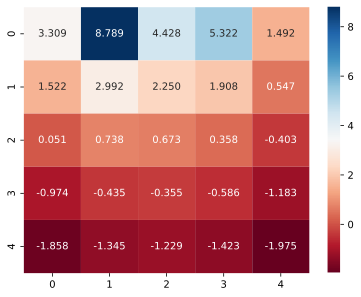

In [3]:
grid = GridWorld(5, 5, [(1, 21, 10), (3, 13, 5)])
values = grid.bellman_solution()
sns.heatmap(values, cmap='RdBu', annot=True, fmt=".3f");

## Action-value function

Value (**expected return**) of following policy $\pi$ after committing action $a$ state $s$:

$$
    q_\pi(s, a) = \mathbb E_\pi[G_t \vert S_t = s, A_t = a]
$$

````{admonition} Question
:class: important
How to write $v_\pi(s)$ in terms of $q_\pi(s, a)$?

```{admonition} Answer
:class: tip, dropdown

$$
v_\pi(s) = \sum\limits_a \pi(a\vert s) q_\pi(s, a)
$$

```
````

> How to write $v_\pi(s)$ in terms of $q_\pi(s, a)$?
> 
> $$
> v_\pi(s) = \sum\limits_a \pi(a\vert s) q_\pi(s, a)
> $$

**Bellman expectation equality** for $q_\pi(s, a)$


MDP-1:

$$
    q_\pi(s,a) = \sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_{\pi}(s'))
$$


Since $v_\pi(s) = \sum\limits_{a} \pi(a\vert s) q_\pi(s, a)$, we obtain

$$
    q_\pi(s,a) = \sum\limits_{r, s'}p(r, s'\vert s, a)\Big(r + \gamma \sum\limits_{a'}\pi(a'\vert s') q_\pi(s', a')\Big)
$$

MDP-2:

$$
    q_\pi(s,a) =  \mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a)\sum\limits_{a'}\pi(a'\vert s') q_\pi(s', a')
$$

Once again the equation stands for some fixed policy $\pi$

## Optimal policy

Optimal policy $\pi_*$ is the one with the largest $v_\pi(s)$:

$$
    v_*(s) = \max\limits_\pi v_\pi(s), \quad v_*(s) = v_{\pi_*}(s)
$$
$$
    q_*(s, a) = \max\limits_\pi q_\pi(s, a), \quad q_*(s, a) = q_{\pi_*}(s, a)
$$

Note that both $v_*(s)$ and $q_*(s, a)$ do not depend on $\pi$ anymore

If we now optimal action-value function $q_*(s, a)$, then the optimal deterministic policy can be found as

$$
    \pi_*(a\vert s) = \begin{cases}
    1, & a = \arg\max\limits_a q_*(s, a), \\
    0, & \text{otherwise}.
    \end{cases}
$$

**Bellman optimality equality** for $v_*(s)$

MDP-1:

$$
v_*(s) = \max\limits_a q_*(s, a) = \max\limits_a\sum\limits_{r, s'}p(r, s'\vert s, a)(r + \gamma v_*(s'))
$$

MDP-2:

$$
v_*(s) = \max\limits_a \Big\{\mathcal R(s, a) + \gamma\sum\limits_{s'}p(s'\vert s, a)v_*(s')\Big\}
$$

```{admonition} Exercise
:class: important
Compute $v_*$ of the best state $A$.
```

> Compute $v_*$ of the best state $A$.

In [4]:
10 / (1- 0.9**5)

24.419428096993972

## Value iteraion

1. Initialize $v_i(s)=0$, for all $s \in \mathcal S$

2. While $\|v_{i+1} - v_i\| > \varepsilon$:
 
3. $\quad v_{i+1}(s) = \max\limits_a \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_{i}(s')\big)$, $s \in \mathcal S$

After $n$ iterations $v_n(s) \approx v_*(s)$ for all $s\in\mathcal S$, so the optimal policy is now evaluated as

$$
    \pi_*(s) = \arg\max\limits_a \sum\limits_{r, s'} p(r, s' | s,a)\big(r + \gamma v_*(s')\big)
$$

**Q.** How to update the value function in MDP-2?

$\quad v_{i+1}(s) = \max\limits_a \big\{\mathcal R(s, a) +\gamma\sum\limits_{s'} p(s' | s,a) v_{i}(s')\big\}$

Apply the value iteration methods to the gridworld environment:

In [5]:
grid = GridWorld(5, 5, [(1, 21, 10), (3, 13, 5)])
for i in range(1000):
    diff = grid.update_state_values()
    print(f"diff at iteration {i}: {diff:.6f}")
    if diff < 1e-3:
        break

diff at iteration 0: 11.180340
diff at iteration 1: 16.837458
diff at iteration 2: 15.153712
diff at iteration 3: 14.390083
diff at iteration 4: 13.201365
diff at iteration 5: 11.359212
diff at iteration 6: 10.087099
diff at iteration 7: 8.899113
diff at iteration 8: 8.128209
diff at iteration 9: 7.426842
diff at iteration 10: 6.520376
diff at iteration 11: 5.832493
diff at iteration 12: 5.165771
diff at iteration 13: 4.786819
diff at iteration 14: 4.422070
diff at iteration 15: 3.967694
diff at iteration 16: 3.580832
diff at iteration 17: 3.102996
diff at iteration 18: 2.886449
diff at iteration 19: 2.703556
diff at iteration 20: 2.447296
diff at iteration 21: 2.182663
diff at iteration 22: 1.821722
diff at iteration 23: 1.697455
diff at iteration 24: 1.627680
diff at iteration 25: 1.530449
diff at iteration 26: 1.368849
diff at iteration 27: 1.087588
diff at iteration 28: 1.036305
diff at iteration 29: 1.036065
diff at iteration 30: 1.016825
diff at iteration 31: 0.915050
diff at ite

## Applications of MDPs

This extends the search algorithms to the case of probabilistic next states.
_Many_ important problems are MDPs...

- Robot path planning
- Travel route planning
- Elevator scheduling
- Bank customer retention
- Autonomous aircraft navigation
- Manufacturing processes
- Network switching & routing

#### Policy Iteration (another way to compute optimal policies)

Write $\pi(S_i) =$ action selected in the $i$’th state. Then $\pi$ is a policy.

Write $\pi^t = t$’th policy on t’th iteration


Algorithm:
$\pi^{\circ} =$ any randomly chosen policy

compute $J^{\circ}(S_i) =$ long term reward starting at $S_i$ using $\pi^{\circ}$

$\pi_1(S_i) = \arg \max\limits_a [r_i + \gamma \sum_j P^a_{ij} J^{\circ}(S_j)]$

$J_1 = \dots$

$\pi_2(S_i) = \dots$

Keep computing $\pi^1 \pi^2 \pi^3 \dots$ until $\pi^k = \pi^{k+1}$. Then one will have an optimal policy.

#### Policy Iteration & Value Iteration: Which is best?


It depends.
- Lots of actions? Choose _Policy Iteration_
- Already got a fair policy? _Policy Iteration_
- Few actions, acyclic? _Value Iteration_

And the best of both worlds:
> Modified Policy Iteration [Puterman]
> 
> A simple mix of value iteration and policy iteration